# 따릉이 대여량 예측

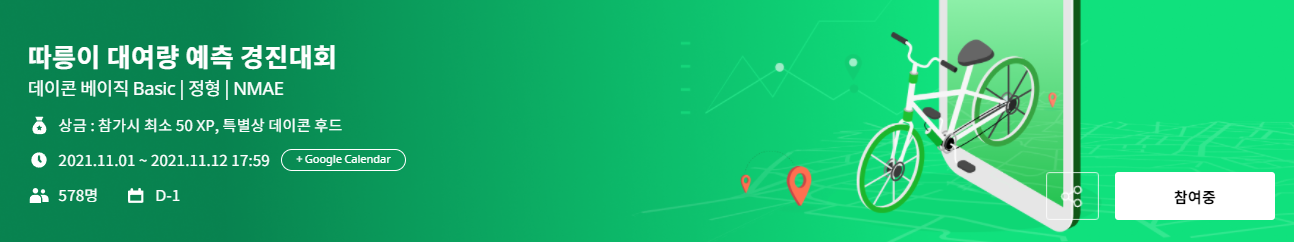

- DACON : [따릉이 대여량 예측](https://dacon.io/competitions/official/235837/overview/description)

무인 공공자전거 대여 서비스인 따릉이는 누구나 손쉽게 이용할 수 있는 자전거 대여 서비스이다. 어플만 있으면 저렴한 가격에 손쉽게 사용이 가능하기 때문에 모두에게나 사랑받고 있다. 따릉이에 대한 수요가 높아 질수록 이에 대한 관리가 필요해 보인다. 자전거의 배치공간은 한계가 있으며 서울에도 지역에 따라 수요가 다르므로 데이터 분석을 통해 따릉이의 대여량을 파악하는 것이 이번 대회의 핵심이다. 데이콘은 서울에 일별, 온도, 습도, 강수량 등 일기예보 데이터와 따릉이의 대여량 데이터를 제공하고, 이 데이터를 통해 따릉이의 대여량을 예측해 보려 한다. 데이콘에서 제공하는 데이터는 다음과 같다.

### Data

기상 데이터는 하루에 총 8번 3시간 간격으로 발표되는 기상단기예보(SHRT) 데이터를 1일 평균으로 변환

- date_time : 일별 날짜
- wind_direction: 풍향 (degree)
- sky_condition : 하늘 상태 
    - 2019년 6월 4일까지 : 맑음(1), 구름조금(2), 구름많음(3), 흐림(4)
    - 2020년 : 맑음(1), 구름많음(3), 흐림(4)
- precipitation_form : 강수 형태 (하단 설명 참조)
    -  precipitation_form (강수 형태) 코드 : 없음(0), 비(1), 진눈깨비(2), 눈(3), 소나기(4)
    - 원본 데이터에는 없음(0), 비(1),소나기(4)가 포함되어있었으며 진눈깨비(2)와 눈(3) 성분은 존재하지 않음.
- wind_speed : 풍속 (m/s)
- humidity : 습도 (%)
- low_temp : 최저 기온 ( `C)
- high_temp : 최고 기온 ( `C)
- Precipitation_Probability : 강수 확률 (%)
- number_of_rentals : 따릉이 대여량

# 1. 라이브러리 및 데이터
우선 라이브러리를 불러와보자. 
- 데이터 전처리를 위해 pandas,numpy를 불러왔고, 
- 데이터 시각화를 위해 matplotlib,seaborn을 불러왔으며,
- sklearn은 머신러닝 라이브러리 이다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')
# 한글폰트
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    print('Mac version')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    print('Windows version')
elif platform.system() == 'Linux':
    path = "/usr/share/fonts/NanumFont/NanumGothicBold.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
    print('Linux version')
else:
    print('Unknown system... sorry~~~~')

Linux version


In [3]:
train = pd.read_csv('data/train.csv', parse_dates=["date_time"])

# 2. 탐색적 자료분석

In [4]:
train.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833


### 2-1. 데이터크기

- 273개의 행과과 10개의 컬럼을 가지고 있다.

In [5]:
train.shape

(273, 10)

### 2-2 컬럼별 자료형
- date_time는 날짜형이고 number_of_rentals는 int64로 포현되있으며 나머지는 float64로 되어있음을 알 수 있다.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date_time                  273 non-null    datetime64[ns]
 1   wind_direction             273 non-null    float64       
 2   sky_condition              273 non-null    float64       
 3   precipitation_form         273 non-null    float64       
 4   wind_speed                 273 non-null    float64       
 5   humidity                   273 non-null    float64       
 6   low_temp                   273 non-null    float64       
 7   high_temp                  273 non-null    float64       
 8   Precipitation_Probability  273 non-null    float64       
 9   number_of_rentals          273 non-null    int64         
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 21.5 KB


### 2-3 결측치 파악
- 결측치를 파악을 했으나 다행이 결측치는 없는걸로 판단 되었다.

In [7]:
train.isnull().sum()

date_time                    0
wind_direction               0
sky_condition                0
precipitation_form           0
wind_speed                   0
humidity                     0
low_temp                     0
high_temp                    0
Precipitation_Probability    0
number_of_rentals            0
dtype: int64

### 2-4 데이터 전처리

#### 날짜 및 변수 추가
date_time를 나누어 year(년),month(월),day(일),weekday(평일,주말)로 나누어 주자.<br>
또한 변수 일교차,온도*습도 컬럼도 추가해 주었다.

In [8]:
train["year"] = train["date_time"].dt.year
train["month"] = train["date_time"].dt.month
train["day"] = train["date_time"].dt.day
train["weekday"] = train["date_time"].dt.weekday
# 1. "일교차가 너무 큰 날씨"를 알기 위한 정보
train['temp_diff_info'] = train['high_temp'] - train['low_temp']
# 2. "온도 * 습도의 날씨 알기 위한 정보"
train['sweat_info'] =  train['high_temp'] * train['humidity']
train['sweat_info2'] = train['low_temp'] * train['humidity']
train.shape

(273, 17)

- 칼럼 10개에서 17개로 늘어난걸 확인 할 수 있다.

In [9]:
train.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day,weekday,temp_diff_info,sweat_info,sweat_info2
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1,6,8.400,1575.000000,945.000000
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2,0,6.188,1326.827000,894.700396
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3,1,5.004,1146.846764,772.152248
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4,2,4.056,888.628432,597.208888
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5,3,4.546,768.903064,433.481000


## 3. 시각화

### 3-1.Barplot

- 년도별 그래프를 보면 매년마다 대여량이 많아지는걸 볼 수 있다.
- 4,5,6월 그래프를 보면 날씨가 따뜻해질수록 대여량이 많아지는걸 볼 수 있다.
- 일별 그래프는 특징을 찾기 어려운거 같다.
- 요일별 그래프는 대여량이 월~토는 비슷하며 일요일은 미미하게 적은걸 확인 할 수 있다.

[Text(0.5, 0, '요일'), Text(0, 0.5, '대여량'), Text(0.5, 1.0, '요일별 대여량')]

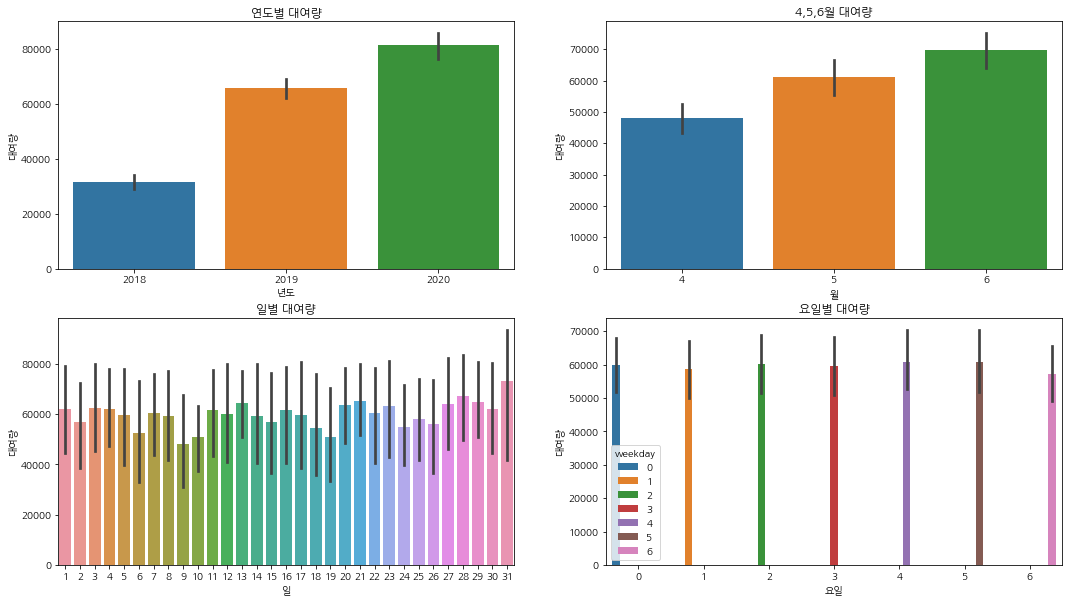

In [10]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(18,10)

sns.barplot(data=train, x="year", y="number_of_rentals", ax=ax1)
sns.barplot(data=train, x="month", y="number_of_rentals", ax=ax2)
sns.barplot(data=train, x="day", y="number_of_rentals", ax=ax3)
sns.barplot(data=train, x="weekday", y="number_of_rentals", hue = "weekday", ax=ax4,)

ax1.set(ylabel='대여량',xlabel='년도', title="연도별 대여량",)
ax2.set(xlabel='월',ylabel='대여량',title="4,5,6월 대여량")
ax3.set(xlabel='일',ylabel='대여량',title="일별 대여량")
ax4.set(xlabel='요일',ylabel='대여량', title="요일별 대여량")

### 3-2 월별 증가량을 일별로 자세히 보자.
- 월,일을 대여량과 그룹해주고 평균을 내어 주었다.
- 3년 데이터를 월과,일 데이터 평균을 구해 주었다.

In [11]:
grouped_df = train.groupby(['month','day'])['number_of_rentals'].mean()

In [12]:
grouped_df 

month  day
4      1      43637.333333
       2      47432.333333
       3      48310.000000
       4      46040.000000
       5      37529.000000
                  ...     
6      26     61271.666667
       27     75787.666667
       28     67793.666667
       29     60054.666667
       30     46663.666667
Name: number_of_rentals, Length: 91, dtype: float64

In [13]:
grouped_df = grouped_df.reset_index()

In [14]:
grouped_df[grouped_df['month'] == 4].head() # 4월만 잘 묶였는지 확인

,month,day,number_of_rentals
0,4,1,43637.333333
1,4,2,47432.333333
2,4,3,48310.000000
3,4,4,46040.000000
4,4,5,37529.000000


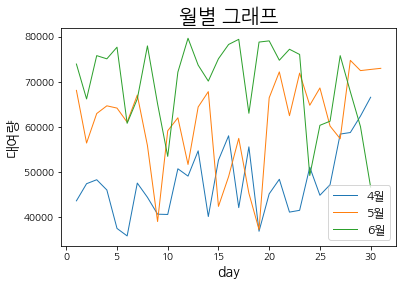

In [15]:
long_df_sub = grouped_df[grouped_df['month'] == 4]
plt.plot(long_df_sub.day, long_df_sub.number_of_rentals, 
         linewidth=1)

long_df_sub = grouped_df[grouped_df['month'] == 5]
plt.plot(long_df_sub.day, long_df_sub.number_of_rentals, 
         linewidth=1)

long_df_sub = grouped_df[grouped_df['month'] == 6]
plt.plot(long_df_sub.day, long_df_sub.number_of_rentals, 
         linewidth=1)
    
plt.legend(['4월', '5월', '6월'], fontsize=12, loc='best')
plt.title('월별 그래프', fontsize=20) 
plt.ylabel('대여량', fontsize=14)
plt.xlabel('day', fontsize=14)
plt.show()

- 그래프를 보면 4월 < 5월 < 6월 대여량에 차이가 있는걸 볼 수 있다.  
- 일별 데이터는 특징을 찾기 어려운거 같다.

### 3-3 연도별로 나누어 자세히 보도록 하자
- 이번에는 연,월,일을 대여량과 그룹해주고 평균을 내주었다.

In [16]:
grouped_df1 = train.groupby(['year','month', 'day'])['number_of_rentals'].mean()

In [17]:
grouped_df1 = grouped_df1.reset_index()

In [55]:
grouped_df1

,year,month,day,number_of_rentals
0,2018,4,1,22994
1,2018,4,2,28139
2,2018,4,3,26817
3,2018,4,4,26034
4,2018,4,5,2833
...,...,...,...,...
268,2020,6,26,96150
269,2020,6,27,107001
270,2020,6,28,98568
271,2020,6,29,70053


- 연도별로 구분을 지어주기위해 데이터셋을 만들어 주었다.

In [19]:
grouped_df_2018 = grouped_df1[grouped_df1['year'] == 2018]
grouped_df_2019 = grouped_df1[grouped_df1['year'] == 2019]
grouped_df_2020 = grouped_df1[grouped_df1['year'] == 2020]

In [20]:
grouped_df_2018.head() # 연도별로 잘 묶였는지 확인.

,year,month,day,number_of_rentals
0,2018,4,1,22994
1,2018,4,2,28139
2,2018,4,3,26817
3,2018,4,4,26034
4,2018,4,5,2833


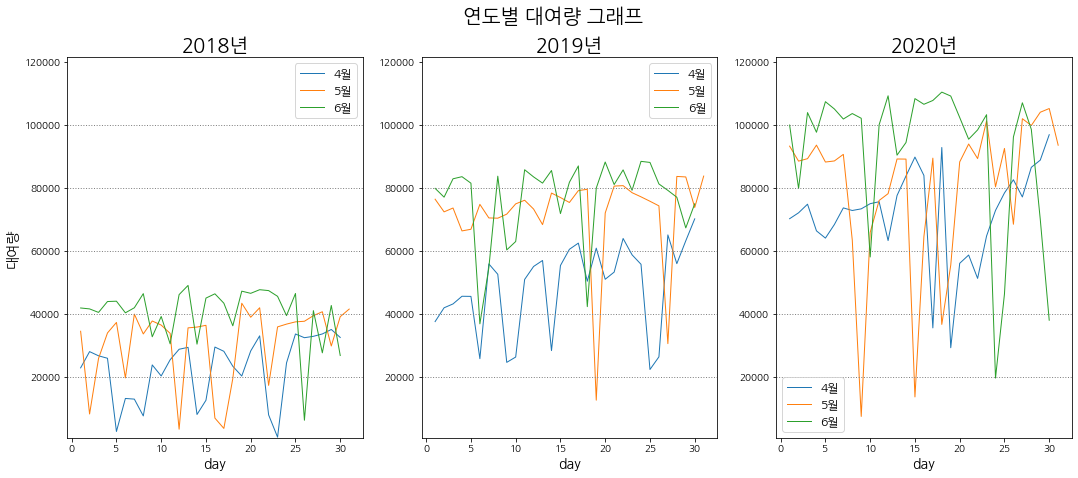

In [21]:
min_value = grouped_df1['number_of_rentals'].min() # 대여량 최소값을 설정
max_value =  grouped_df1['number_of_rentals'].max() # 대여량 최대값을 설정

fig = plt.figure() 
fig.set_size_inches(18,7) # 그래프 사이즈 설정
plt.suptitle('연도별 대여량 그래프', fontsize=20) # 메인 제목

ax1 = fig.add_subplot(1,3,1) # 1,3,1 = 그래프 행개수,열개수,그래프순서 
groups = [4, 5, 6]
linewidths = [1, 1, 1] # 선 크기.

for group_name, size in zip(groups, linewidths):
    # subsetting
    long_df_sub = grouped_df_2018[grouped_df_2018['month'] == group_name]
    # plotting
    plt.plot(long_df_sub.day, long_df_sub.number_of_rentals, linewidth=size)

# y축 범위
plt.ylim([min_value*0.8, max_value*1.1]) 

# 가로선
plt.axhline(y=20000, color='gray', linewidth=1,linestyle=':')
plt.axhline(y=40000, color='gray', linewidth=1,linestyle=':')
plt.axhline(y=60000, color='gray', linewidth=1, linestyle=':')
plt.axhline(y=80000, color='gray', linewidth=1, linestyle=':')
plt.axhline(y=100000, color='gray', linewidth=1, linestyle=':')

plt.legend(['4월', '5월', '6월'], fontsize=12, loc='best') # 범례, 폰트크기, 위치(best:그래프 안가리는 위치)
plt.title('2018년', fontsize=20) # 그래프 제목
plt.ylabel('대여량', fontsize=14) # y축 이름
plt.xlabel('day', fontsize=14) # x축 이름

ax2 = fig.add_subplot(1,3,2) # 1,3,2 = 그래프 행개수,열개수,그래프순서 

linewidths = [1, 1, 1] # 선 크기.

for group_name, size in zip(groups, linewidths):
    # subsetting
    long_df_sub = grouped_df_2019[grouped_df_2019['month'] == group_name]
    # plotting
    plt.plot(long_df_sub.day, long_df_sub.number_of_rentals, linewidth=size)

# y축 범위
plt.ylim([min_value*0.8, max_value*1.1]) 

# 가로선
plt.axhline(y=20000, color='gray', linewidth=1,linestyle=':')
plt.axhline(y=40000, color='gray', linewidth=1,linestyle=':')
plt.axhline(y=60000, color='gray', linewidth=1, linestyle=':')
plt.axhline(y=80000, color='gray', linewidth=1, linestyle=':')
plt.axhline(y=100000, color='gray', linewidth=1, linestyle=':')

plt.legend(['4월', '5월', '6월'], fontsize=12, loc='best') # 범례, 폰트크기, 위치(best:그래프 안가리는 위치)
plt.title('2019년', fontsize=20) # 그래프 제목
plt.xlabel('day', fontsize=14) # x축 이름

ax3 = fig.add_subplot(1,3,3)# 1,3,3 = 그래프 행개수,열개수,그래프순서 

linewidths = [1, 1, 1] # 선 크기.

for group_name, size in zip(groups, linewidths):
    # subsetting
    long_df_sub = grouped_df_2020[grouped_df_2020['month'] == group_name]
    # plotting
    plt.plot(long_df_sub.day, long_df_sub.number_of_rentals, linewidth=size)

# y축 범위
plt.ylim([min_value*0.8, max_value*1.1]) 

# 가로선
plt.axhline(y=20000, color='gray', linewidth=1,linestyle=':')
plt.axhline(y=40000, color='gray', linewidth=1,linestyle=':')
plt.axhline(y=60000, color='gray', linewidth=1, linestyle=':')
plt.axhline(y=80000, color='gray', linewidth=1, linestyle=':')
plt.axhline(y=100000, color='gray', linewidth=1, linestyle=':')

plt.legend(['4월', '5월', '6월'], fontsize=12, loc='best') # 범례, 폰트크기, 위치(best:그래프 안가리는 위치)
plt.title('2020년', fontsize=20) # 그래프 제목
plt.xlabel('day', fontsize=14) # x축 이름
plt.show()

### 3-4 Heatmap

- 따릉이 대여량의 상관분석을 살펴 보면 풍속,강수,풍속,습도,강수확률은 음의 상관 관계,풍향,온도는 양의 상관관계를 보이고 있다. <br> 좀더 자세하게 그래프로 확인해 보자.

In [23]:
corrMatt = train[["wind_direction",'sky_condition','precipitation_form','wind_speed','humidity','Precipitation_Probability',
                  'low_temp','high_temp','temp_diff_info','sweat_info','sweat_info2','number_of_rentals']]
corrMatt = corrMatt.corr()

<AxesSubplot:>

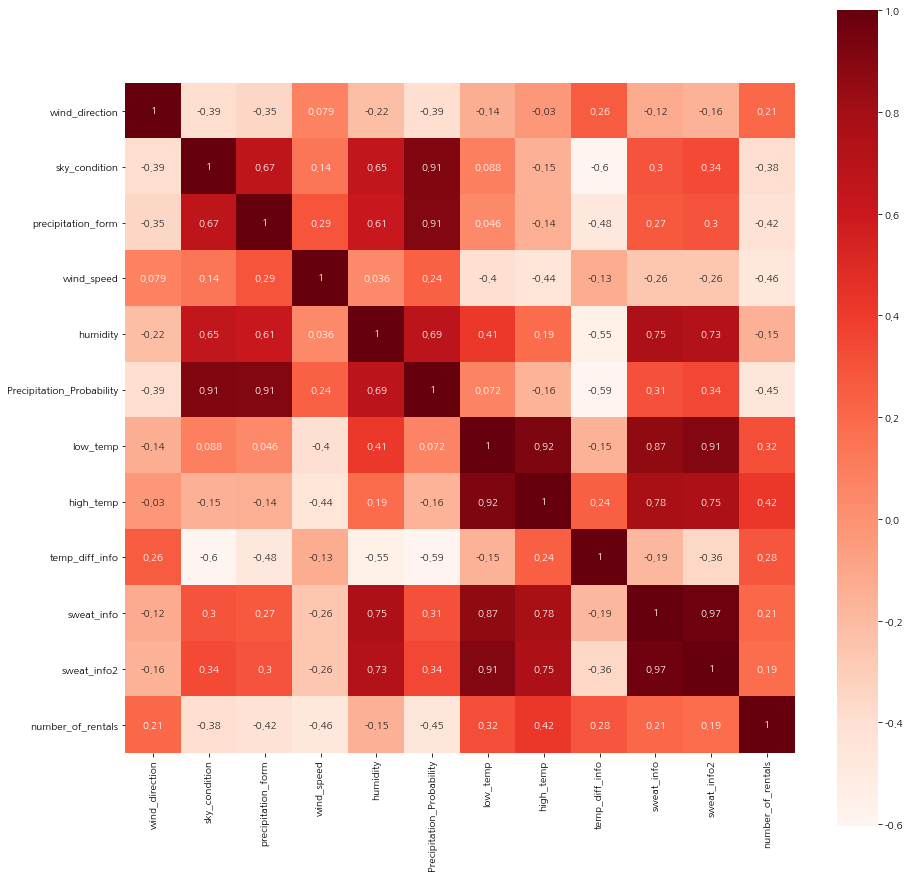

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(15,15)
sns.heatmap(corrMatt,annot=True, square=True, cmap ='Reds')

### 3-5 Regplot
### 3-5-1 날씨, 강수량, 강수확률에 대한 대여량
- 날씨별 대여량을 확인하면 맑음(1)때 대여량이 많고, 날씨가 흐림(4)으로 갈때 대여량이 낮아지는 것을 볼 수 있다.
- 강수량별 대여량을 확인하면 0 ~ 1(없음~비) 비가 안올때 대여량이 많은걸 확인 할 수 있다.
- 강수확률별 대여량 확인하면 강수확률이 낮을때 대여량이 많은것을 확인 할 수 있다.

[Text(0.5, 0, '강수확률'), Text(0, 0.5, '대여량'), Text(0.5, 1.0, '강수확률별 대여량')]

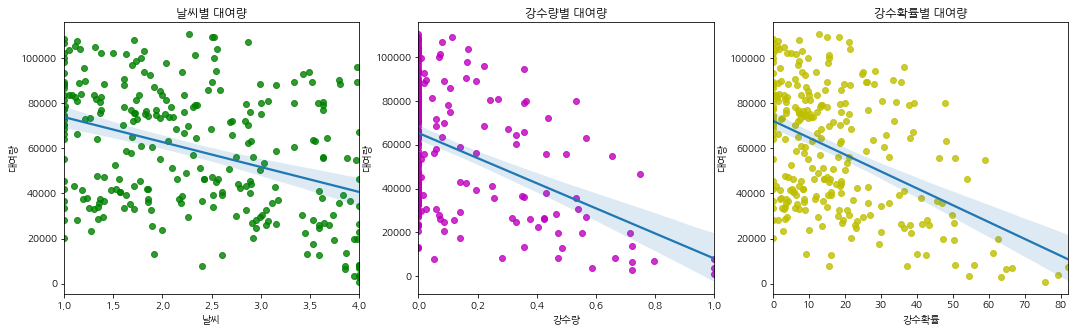

In [25]:
figure, ((ax1,ax2,ax3)) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18,5)
sns.regplot(data=train, x='sky_condition', y='number_of_rentals', scatter_kws={'color': 'g'}, ax=ax1)
sns.regplot(data=train, x='precipitation_form', y='number_of_rentals', scatter_kws={'color':'m'}, ax=ax2)
sns.regplot(data=train, x='Precipitation_Probability', y='number_of_rentals',scatter_kws={'color':'y'},ax=ax3)

ax1.set(xlabel='날씨',ylabel='대여량', title='날씨별 대여량')
ax2.set(xlabel='강수량',ylabel='대여량', title='강수량별 대여량')
ax3.set(xlabel='강수확률',ylabel='대여량', title='강수확률별 대여량')

### 3-5-2 온도에 대한 대여량
- 최저,최고온도별 대여량을 보면 온도가 높아야 대여량이 증가하는것을 볼 수 있다.

[Text(0.5, 0, '최저온도'), Text(0, 0.5, '대여량'), Text(0.5, 1.0, '최저온도별 대여량')]

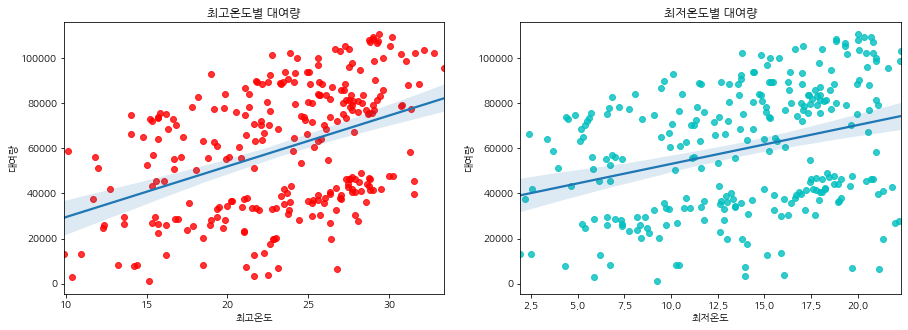

In [59]:
figure, ((ax1,ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(15,5)

sns.regplot(data=train, x='high_temp', y='number_of_rentals', scatter_kws={'color':'r'}, ax=ax1)
sns.regplot(data=train, x='low_temp', y='number_of_rentals', scatter_kws={'color':'c'}, ax=ax2)

ax1.set(xlabel='최고온도',ylabel='대여량', title='최고온도별 대여량')
ax2.set(xlabel='최저온도',ylabel='대여량', title='최저온도별 대여량')

### 3-5-3 최고, 최저온도 * 습도에 대한 대여량

[Text(0.5, 0, '최저온도*습도'), Text(0, 0.5, '대여량'), Text(0.5, 1.0, '')]

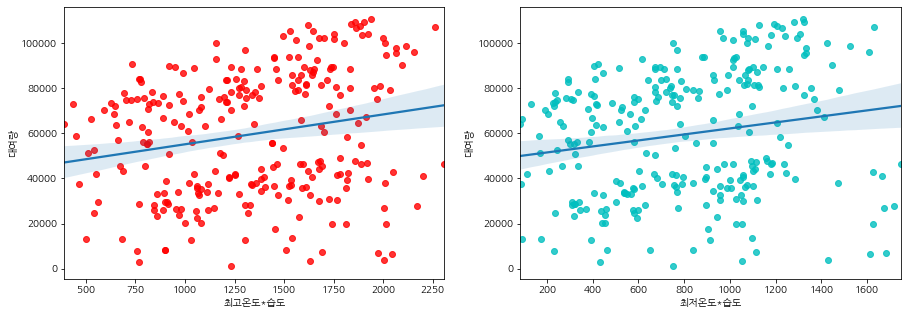

In [58]:
figure, ((ax1,ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(15,5)

sns.regplot(data=train, x='sweat_info', y='number_of_rentals', scatter_kws={'color':'r'}, ax=ax1)
sns.regplot(data=train, x='sweat_info2', y='number_of_rentals', scatter_kws={'color':'c'}, ax=ax2)

ax1.set(xlabel='최고온도*습도',ylabel='대여량', title='')
ax2.set(xlabel='최저온도*습도',ylabel='대여량', title='')

- 위 결과를 보면 습도와 온도가 높으면 대여량이 많이 없는것을 확인 할 수 있다.
- 적당한 온도와 습도일때 대여량이 많아 보인다.

### 3-3-4 일교차에 대한 대여량

Text(0.5, 1.0, '일교차에 따른 대여량')

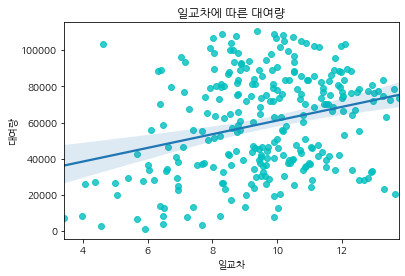

In [29]:
sns.regplot(data=train, x='temp_diff_info',y='number_of_rentals', scatter_kws={'color':'c'})
plt.xlabel("일교차")
plt.ylabel("대여량")
plt.title("일교차에 따른 대여량")

일교차 그래프는 특정하기 어려운거 같다. 일교차가 크다고 대여량이 없을것이다 생각했는데 이시기는 여름이다. 자전거타기 아주 좋은 시기라 특징을 찾기는 어려워 보인다.

## 4. 변수 및 모델 정의
우리의 목적은 주어진 날씨 데이터를 이용해 따릉이 대여량을 예측하는 것이다.<br>
날씨 데이터가 X, 따릉이 대여 수가 y가 되야 한다.

In [30]:
X = train.drop(['date_time', 'number_of_rentals'], axis=1)
y = train.number_of_rentals

In [31]:
X

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day,weekday,temp_diff_info,sweat_info,sweat_info2
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,2018,4,1,6,8.400,1575.000000,945.000000
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,2018,4,2,0,6.188,1326.827000,894.700396
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,2018,4,3,1,5.004,1146.846764,772.152248
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,2018,4,4,2,4.056,888.628432,597.208888
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2018,4,5,3,4.546,768.903064,433.481000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,228.662,3.980,0.223,2.271,78.378,20.500,27.526,36.486,2020,6,26,4,7.026,2157.432828,1606.749000
269,207.770,2.865,0.081,1.794,78.412,20.812,28.842,21.081,2020,6,27,5,8.030,2261.558904,1631.910544
270,282.568,1.730,0.000,1.820,72.736,21.000,29.053,7.297,2020,6,28,6,8.053,2113.199008,1527.456000
271,137.027,2.257,0.088,2.043,70.473,19.625,26.000,15.541,2020,6,29,0,6.375,1832.298000,1383.032625


## 4-1 성능 확인

In [61]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [62]:
y_hat = model.predict(X)

In [73]:
nmae = np.mean(abs(y_hat - y) / y) # nmae 계산

print(f'모델 NMAE: {nmae}')

모델 NMAE: 0.300390550014234


- 평가지수 NAMA로 계산하여 오차율이 30%정도로 나왔다. 

# 4-2. 예측값 시각화

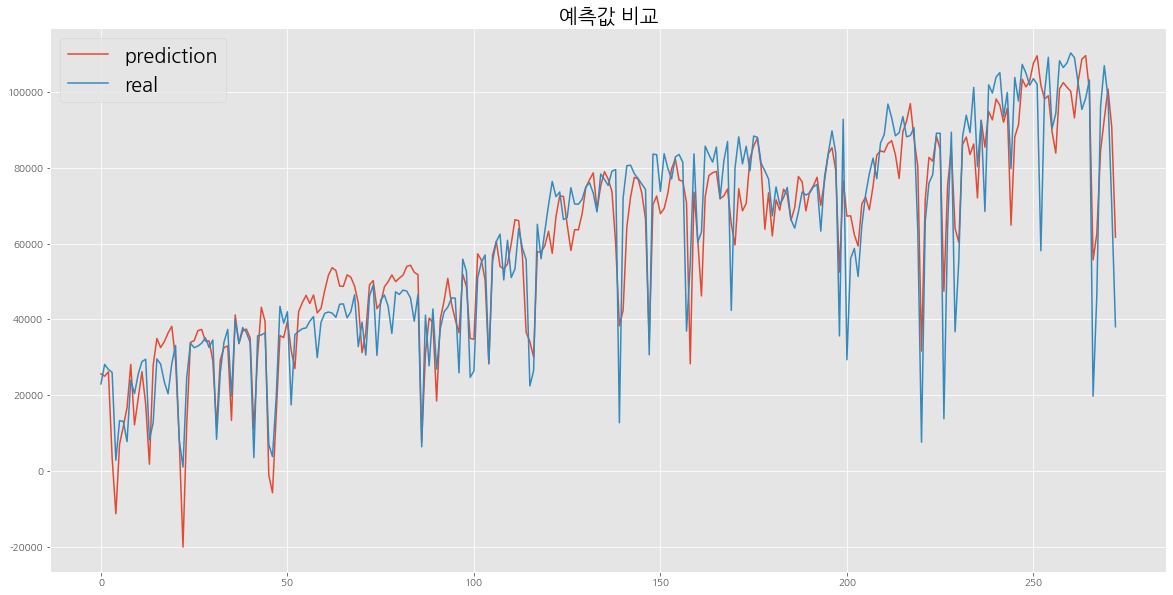

In [84]:
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
plt.plot(y_hat, label = 'prediction')
plt.plot(y, label = 'real')
plt.legend(fontsize = 20)
plt.title("예측값 비교", fontsize = 20)
plt.show()

- 그래프를 보면 예측값이 어느정도 따라가고 있는거 같다.

## 4.Submission 제출
### 4-1 데이터 로드

In [68]:
test = pd.read_csv('data/test.csv', parse_dates=["date_time"])
submission = pd.read_csv('data/sample_submission.csv')

In [69]:
test.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability
0,2021-04-01,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333
1,2021-04-02,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500
2,2021-04-03,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847
3,2021-04-04,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671
4,2021-04-05,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459


### 4-2 데이터 결측치 파악

In [49]:
test.isnull().sum()

date_time                    0
wind_direction               0
sky_condition                0
precipitation_form           0
wind_speed                   0
humidity                     0
low_temp                     0
high_temp                    0
Precipitation_Probability    0
dtype: int64

### 4-3 데이터 전처리

In [70]:
test["year"] = test["date_time"].dt.year
test["month"] = test["date_time"].dt.month
test["day"] = test["date_time"].dt.day
test["weekday"] = test["date_time"].dt.weekday
# 1. "일교차가 너무 큰 날씨"를 알기 위한 정보
test['temp_diff_info'] = test['high_temp'] - test['low_temp']
# 2. "온도 * 습도의 날씨 알기 위한 정보"
test['sweat_info'] =  test['high_temp'] * test['humidity']
test['sweat_info2'] = test['low_temp'] * test['humidity']
test.shape

# date_time은 제거
test_X = test.drop('date_time', axis = 1)

In [71]:
test_X.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day,weekday,temp_diff_info,sweat_info,sweat_info2
0,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333,2021,4,1,3,8.867,585.558111,334.329400
1,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500,2021,4,2,4,7.000,881.923000,557.004000
2,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847,2021,4,3,5,7.493,1264.558944,685.664750
3,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671,2021,4,4,6,11.118,1099.185984,395.550000
4,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459,2021,4,5,0,11.496,900.120384,346.289088


In [72]:
# train data로 학습시킨 모델에 test_X데이터를 넣고 예측합니다.
test_yhat = model.predict(test_X)

#submission dataFrame 완성
submission['number_of_rentals'] = test_yhat

# 제출 파일 생성
submission.to_csv('submission.csv', index=False)

# 참고
- Dacon Baseline: [1. 데이터 분석 입문자를 위한 데이터 분석 & 예측](https://dacon.io/competitions/official/235837/codeshare/3686?page=1&dtype=recent)